In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import random
from matplotlib.colors import ListedColormap, Normalize
import pickle
from scipy.interpolate import interp1d
import sympy as sp
from scipy.optimize import root
import seaborn as sns
from sympy import symbols, diff
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

# Turing island identification

In [ ]:
def compute_ss_region(params, xmin, xmax, ymin, ymax, factor): #The factor is the resolution of the image
    xval = np.linspace(xmin, xmax, int((xmax - xmin) * factor))
    yval = np.linspace(ymin, ymax, int((ymax - ymin) * factor))
    X, Y = np.meshgrid(xval, yval)
    ss_a_region = np.zeros_like(X)
    ss_b_region = np.zeros_like(X)
    b_a, v_a, k_a,a,b, k_ba, mu_a = symbols('b_a v_a k_a a b k_ba mu_a', real=True)
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
    b_b, v_b, k_ab,a,b, mu_b = symbols('b_b v_b k_ab a b mu_b', real=True)
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b
    r_d_a_a = diff(r_d_a, a)
    r_d_a_b = diff(r_d_a, b)

    r_d_b_b = diff(r_d_b, b)
    r_d_b_a = diff(r_d_b, a)
    
    mod_pars = params[2:]
    values_base = {
        b_a: mod_pars[3], v_a: mod_pars[0], k_ba: mod_pars[2], mu_a: mod_pars[5],
        b_b: mod_pars[4], v_b: mod_pars[1], mu_b: mod_pars[6] # Fixed values
    }
    D_a = params[0]
    D_b = params[1]
    
    for i, k_a_val in enumerate(xval):
        for j, k_ab_val in enumerate(yval):
            values = values_base.copy()
            values[k_a] = k_a_val
            values[k_ab] = k_ab_val
            ss = solve_ss(k_a_val, k_ab_val, params)
            ss_a_region[j,i] = ss[0]
            ss_b_region[j,i] = ss[1]
    return X, Y, ss_a_region,ss_b_region
        
def compute_turing_region(params, xmin, xmax, ymin, ymax, factor,ss_a_region, ss_b_region): #The factor is the resolution of the image
    xval = np.linspace(xmin, xmax, int((xmax - xmin) * factor))
    yval = np.linspace(ymin, ymax, int((ymax - ymin) * factor))
    X, Y = np.meshgrid(xval, yval)
    Turing_region = np.zeros_like(X)
    b_a, v_a, k_a,a,b, k_ba, mu_a = symbols('b_a v_a k_a a b k_ba mu_a', real=True)
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
    b_b, v_b, k_ab,a,b, mu_b = symbols('b_b v_b k_ab a b mu_b', real=True)
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b
    r_d_a_a = diff(r_d_a, a)
    r_d_a_b = diff(r_d_a, b)

    r_d_b_b = diff(r_d_b, b)
    r_d_b_a = diff(r_d_b, a)
    
    mod_pars = params[2:]
    values_base = {
        b_a: mod_pars[3], v_a: mod_pars[0], k_ba: mod_pars[2], mu_a: mod_pars[5],
        b_b: mod_pars[4], v_b: mod_pars[1], mu_b: mod_pars[6] # Fixed values
    }
    D_a = params[0]
    D_b = params[1]
    
    for i, k_a_val in enumerate(xval):
        for j, k_ab_val in enumerate(yval):
            values = values_base.copy()
            values[k_a] = k_a_val
            values[k_ab] = k_ab_val
            ss2 = solve_ss2(k_a_val, k_ab_val, params,[ss_a_region[j,i],ss_b_region[j,i]])
            values[a] = ss2[0]
            values[b] = ss2[1]
            J = np.array([
                [r_d_a_a.subs(values).evalf(), r_d_a_b.subs(values).evalf()],
                [r_d_b_a.subs(values).evalf(), r_d_b_b.subs(values).evalf()]
            ], dtype=float)
            real_lambda = []
            k_values = np.linspace(0,2,100)
            for k in k_values:
                J_diff = J - np.diag([D_a * k**2, D_b * k**2])
                eig_vals = np.real(np.linalg.eigvals(J_diff))
                max_real_lambda = np.max(eig_vals)
                real_lambda.append(max_real_lambda)
            lambda_0 = real_lambda[0]
            lambda_max = max(real_lambda)
            index_max = np.argmax(real_lambda)
            # Proper Turing instability
            if lambda_max > 0 and lambda_0 < 0 and index_max != 0:
                Turing_region[j, i] = lambda_max
            else:
                Turing_region[j, i] = -1
    return X, Y, Turing_region

X, Y, ss_a_region,ss_b_region = compute_ss_region(params, 0, 30, 15,50, 6)
X, Y, Turing_region = compute_turing_region(params, 0, 30, 15,50, 6,ss_a_region,ss_b_region)
np.savez('turing_region.npz', X=X, Y=Y, Turing_region=Turing_region,ss_a_region = ss_a_region,ss_b_region = ss_b_region)


In [ ]:
tr = np.load('turing_region.npz')
X = tr['X']
Y = tr['Y']
Turing_region = tr['Turing_region']

# Steady state solvers and approximators
The follwoing contains the steady state solver and the approximator for pattern formation. The details of this can be found in the supplementary information. 

In [4]:

#Steady state solver
def solve_ss(k1, k2, params):

    # Define symbolic variables
    a, b = sp.symbols('a b', real=True)
    b_a, v_a, k_a, k_ba, mu_a = sp.symbols('b_a v_a k_a k_ba mu_a', real=True)
    b_b, v_b, k_ab, mu_b = sp.symbols('b_b v_b k_ab mu_b', real=True)

    # Define steady-state equations
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b
    # Assign values to variables
    mod_pars = params[2:]
    values = {
        b_a: mod_pars[3], v_a: mod_pars[0], k_ba: mod_pars[2], mu_a: mod_pars[5],
        b_b: mod_pars[4], v_b: mod_pars[1], mu_b: mod_pars[6],k_a: k1,k_ab: k2,
    }

    # Convert symbolic expressions into numerical functions
    r_d_a_num = sp.lambdify((a, b), r_d_a.subs(values), 'numpy')
    r_d_b_num = sp.lambdify((a, b), r_d_b.subs(values), 'numpy')

    # Define system of equations
    def equations(vars):
        a, b = vars
        return np.array([r_d_a_num(a, b), r_d_b_num(a, b)])

    # Try multiple solvers for robustness
    initial_guesses = [[4, 2], [1, 1], [10, 5], [0.1, 0.1]]
    solvers = ['hybr', 'lm', 'broyden1', 'df-sane']
    
    for guess in initial_guesses:
        for method in solvers:
            result = root(equations, guess, method=method)
            if result.success:
                return result.x  # Return solution if successful

    raise RuntimeError("No solution found with tested solvers and initial guesses.")

#Steady state solver (informed, using precomputed values for accuracy)
def solve_ss2(k1, k2, params,given_sol):
    # Define symbolic variables
    a, b = sp.symbols('a b', real=True)
    b_a, v_a, k_a, k_ba, mu_a = sp.symbols('b_a v_a k_a k_ba mu_a', real=True)
    b_b, v_b, k_ab, mu_b = sp.symbols('b_b v_b k_ab mu_b', real=True)

    # Define steady-state equations
    r_d_a = b_a + v_a * 1 / (1 + (k_a / a) ** 2) * 1 / (1 + (b / k_ba) ** 2) - mu_a * a
    r_d_b = b_b + v_b * 1 / (1 + (k_ab / a) ** 2) - mu_b * b

    # Assign values to variables
    mod_pars = params[2:]
    values = {
        b_a: mod_pars[3],
        v_a: mod_pars[0],
        k_ba: mod_pars[2],
        mu_a: mod_pars[5],
        b_b: mod_pars[4],
        v_b: mod_pars[1],
        mu_b: mod_pars[6],
        k_a: k1,
        k_ab: k2,
    }

    # Convert symbolic expressions into numerical functions
    r_d_a_num = r_d_a.subs(values)
    r_d_b_num = r_d_b.subs(values)

    # Define system of equations
    def equations(vars):
        a_val, b_val = vars
        return np.array([r_d_a_func(a_val, b_val), r_d_b_func(a_val, b_val)])

    # steady_state = given_sol
    # u0 = sp.nsolve([r_d_a_num, r_d_b_num], [a, b], steady_state, prec = 100)
    # return u0

    # Try multiple initial guesses
    initial_guesses = [given_sol, [0.1, 0.1], [1, 1], [4, 2], [10, 5]]

    for guess in initial_guesses:
        try:
            sol = sp.nsolve([r_d_a_num, r_d_b_num], [a, b], guess, prec=20)
            return sol
        except Exception:
            continue

    raise RuntimeError("No solution found with any initial guess in solve_ss2")
    
def Net8_pat(a, b, mod_pars, k1, k2):  # Reaction terms
    v_a, v_b, k_ba, b_a, b_b, mu_a, mu_b = mod_pars
    k_a, k_ab = k1, k2

    # Clamp a and b to avoid division by zero or overflow
    a_safe = np.clip(a, 1e-8, None)
    b_safe = np.clip(b, 1e-8, None)

    f1 = b_a + v_a * (1 / (1 + (k_a / a_safe) ** 2)) * (1 / (1 + (b_safe / k_ba) ** 2)) - mu_a * a
    f2 = b_b + v_b * (1 / (1 + (k_ab / a_safe) ** 2)) - mu_b * b

    return f1, f2



def Net8_cycle(k1, k2, radius, speed_r, speed_theta, cent_cyc, tangential_noise, radial_noise):
    # Center coordinates
    k1star, k2star = cent_cyc
    x = k1 - k1star
    y = k2 - k2star
    r = np.sqrt(x**2 + y**2)

    # Core deterministic dynamics
    lin1 = x * (speed_r * (radius - r))
    lin2 = y * (speed_r * (radius - r))
    an1 = y * speed_theta
    an2 = x * speed_theta

    # Unit radial and tangential vectors
    if r == 0:
        unit_r = [1.0, 0.0]
        unit_t = [0.0, 1.0]
    else:
        unit_r = [x / r, y / r]
        unit_t = [-y / r, x / r]

    # Add radial noise (in/out movement)
    rad_noise = np.random.normal(0, radial_noise)
    rad_x = rad_noise * unit_r[0]
    rad_y = rad_noise * unit_r[1]

    # Add tangential noise (spin variation)
    tang_noise = np.random.normal(0, tangential_noise)
    tang_x = tang_noise * unit_t[0]
    tang_y = tang_noise * unit_t[1]

    # Final dynamics
    f1 = lin1 - an1 + rad_x + tang_x
    f2 = lin2 + an2 + rad_y + tang_y

    return f1, f2

def soft_clip(x, floor=1e-10):
    return np.where(x < floor, floor, x)

def simulate_LC_TP(
    y0, t0, t_max, dt, c, dx, bound_cond, modelfuns, r,
    noise_amp, v_r, v_theta, cent_cyc, k1_0, k2_0,tangential_noise, radial_noise
):
    def apply_boundary(u):
        if bound_cond == 'Neumann':
            u[:, 0] = u[:, 1]
            u[:, -1] = u[:, -2]
            u[0, :] = u[1, :]
            u[-1, :] = u[-2, :]
        return u

    def laplacian(u):
        u = apply_boundary(u)
        return (
            -4 * u +
            np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
            np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1)
        ) / dx**2

    # Setup initial conditions
    dim = int(np.sqrt(len(y0[:-2]) // 2))  # infer grid size
    params = c
    mod_pars = params[2:]
    ss1 = solve_ss(k1_0,k2_0,params)[0]
    ss2 = solve_ss(k1_0,k2_0,params)[1]
    ss_1 = float(solve_ss2(k1_0,k2_0,params,[ss1,ss2])[0])
    ss_2 = float(solve_ss2(k1_0,k2_0,params,[ss1,ss2])[1])
    a = np.reshape(np.zeros(dim*dim) + ss_1,(dim,dim)) # Initialise Uniform steady state concentration of a and b
    b = np.reshape(np.zeros(dim*dim) + ss_2,(dim,dim)) 
    k1 = k1_0 # Initial k1 k2.
    k2 = k2_0
    t = t0
    results = []  # List to store time, concentrations, and rate constants
    n = 0
    while t < t_max:
        a = apply_boundary(a)
        b = apply_boundary(b)

        # Compute reaction terms for current concentrations
        f1_now, f2_now = modelfuns[0](a, b, mod_pars, k1, k2)
        g1_now, g2_now = modelfuns[1](k1, k2, r, v_r, v_theta, cent_cyc,tangential_noise, radial_noise)

        Da = params[0]
        Db = params[1]

        lap_a = laplacian(a)
        lap_b = laplacian(b)

        dydt_a = Da * lap_a + f1_now 
        dydt_b = Db * lap_b + f2_now 

        #concentration prediction (first step)
        a_pred = a + dt * dydt_a
        b_pred = b + dt * dydt_b

        k1_pred = k1 + dt * g1_now
        k2_pred = k2 + dt * g2_now

        # Get the predicted reaction terms for the predicted concentrations
        f1_pred, f2_pred = modelfuns[0](a_pred, b_pred, mod_pars, k1_pred, k2_pred)
        g1_pred, g2_pred = modelfuns[1](k1_pred, k2_pred, r, v_r, v_theta, cent_cyc,tangential_noise, radial_noise)

        # Second step
        lap_a_pred = laplacian(a_pred)
        lap_b_pred = laplacian(b_pred)

        dydt_a_pred = Da * lap_a_pred + f1_pred
        dydt_b_pred = Db * lap_b_pred + f2_pred

        #Noise terms
        noise_a = a*(noise_amp * np.sqrt(dt) * np.random.randn(*a.shape))
        noise_b = b*(noise_amp * np.sqrt(dt) * np.random.randn(*b.shape))

        # Final update step using both predicted and current steps
        a += 0.5 * dt * (dydt_a + dydt_a_pred) + noise_a
        b += 0.5 * dt * (dydt_b + dydt_b_pred) + noise_b

        # Prevent negative or NaN values
        a = np.nan_to_num(a, nan=0.0, posinf=1e10, neginf=0.0)
        b = np.nan_to_num(b, nan=0.0, posinf=1e10, neginf=0.0)

        a = np.clip(a, 1e-10, None)  # Enforces a minimum of 0
        b = np.clip(b, 1e-10, None)

        
        # Compute the rate of change of k1 and k2 (using the limit cycle dynamics)
        k1 += 0.5 * dt * (g1_now + g1_pred)
        k2 += 0.5 * dt * (g2_now + g2_pred)
        # Store time, concentration, and parameters at each time step
        if int(n%(1/dt)) == 0.0: 
            results.append({
                't': t,   # Current time
                'u': a.copy(),  # Concentration of A (u)
                'v': b.copy(),  # Concentration of B (v)
                'k1': k1,  # Reaction rate constant k1
                'k2': k2   # Reaction rate constant k2
            })
        n += 1
        t += dt


    return results



# Figure A,D,E,F,G,H

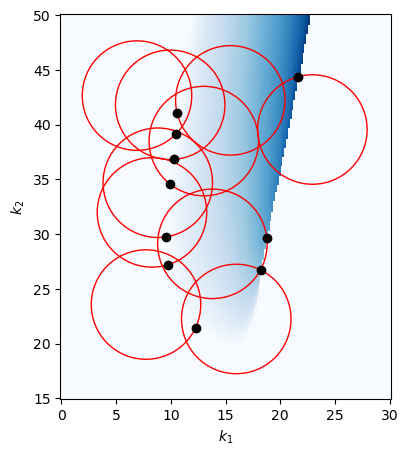

In [22]:

def find_circle_turing_intersections(Turing_region, X, Y, num_circles=5, radius=5):
    turing_mask = Turing_region > 0
    found_centers = []
    entrance_points = []

    height, width = Turing_region.shape
    x_coords = X[0, :]
    y_coords = Y[:, 0]
    
    for _ in range(num_circles):
        attempts = 0
        while attempts < 1000:
            # Random center within bounds
            cx = np.random.uniform(x_coords[0] + radius, x_coords[-1] - radius)
            cy = np.random.uniform(y_coords[0] + radius, y_coords[-1] - radius)
            
            # Sample points on circle
            theta = np.linspace(0, 2*np.pi, 360)
            xs = cx + radius * np.cos(theta)
            ys = cy + radius * np.sin(theta)

            circle_vals = []
            circle_inside = True
            intersects = False
            for x, y in zip(xs, ys):
                # Nearest grid indices
                ix = np.searchsorted(x_coords, x)
                iy = np.searchsorted(y_coords, y)

                if ix <= 0 or iy <= 0 or ix >= width or iy >= height:
                    val = 0
                    circle_inside = False
                else:
                    val = turing_mask[iy, ix]
                    if val == 1:
                        intersects = True
                circle_vals.append(val)

            if not intersects:
                attempts += 1
                continue

            # Find entrance point: 0 → 1 transition
            entrance_index = None
            for i in range(len(circle_vals)):
                prev = circle_vals[i - 1]
                curr = circle_vals[i]
                if prev == 0 and curr == 1:
                    entrance_index = i
                    break

            if entrance_index is None and all(circle_vals):
                # Entire circle inside region
                entrance_index = random.randint(0, len(xs) - 1)

            entrance_point = (xs[entrance_index], ys[entrance_index])
            found_centers.append((cx, cy))
            entrance_points.append(entrance_point)
            break

    return found_centers, entrance_points

# Example usage
centers, entrances = find_circle_turing_intersections(Turing_region, X, Y, num_circles=10, radius=5)
cmap = plt.cm.Blues.copy()
cmap.set_bad(color="white")  # NaN → white

# Continuous normalization (0 → light blue, 1 → dark blue)
norm = Normalize(vmin=0, vmax=np.max(Turing_region))

plt.figure(figsize=(6, 5))
pcm = plt.pcolormesh(X, Y, Turing_region, shading="auto", cmap=cmap, norm=norm)
plt.xlabel(r"$k_1$")
plt.ylabel(r"$k_2$")
for (cx, cy), (ex, ey) in zip(centers, entrances):
    circle = plt.Circle((cx, cy), 5, color='red', fill=False)
    plt.gca().add_patch(circle)
    plt.plot(ex, ey, 'ko')  # Entrance point
plt.gca().set_aspect('equal')
plt.show()

with open("centers.pkl", "wb") as f:
    pickle.dump(centers, f)

with open("entrances.pkl", "wb") as f:
    pickle.dump(entrances, f)

Circle 1 at (6.911607466795349, 42.66000117829911): 21.7% inside Turing region
Circle 2 at (8.809476727259664, 34.70080160935739): 42.8% inside Turing region
Circle 3 at (8.277605748580367, 31.98994957390635): 39.4% inside Turing region
Circle 4 at (9.941821708064465, 41.81767050770186): 45.0% inside Turing region
Circle 5 at (15.978374140149128, 22.256385729291168): 31.1% inside Turing region
Circle 6 at (13.0163162287472, 38.505358175996605): 67.8% inside Turing region
Circle 7 at (22.930986987082083, 39.560409308951414): 35.6% inside Turing region
Circle 8 at (7.732799803441843, 23.5727052642063): 26.4% inside Turing region
Circle 9 at (13.795654887750612, 29.1180236073396): 71.4% inside Turing region
Circle 10 at (15.435780869112834, 42.22370173376215): 88.3% inside Turing region


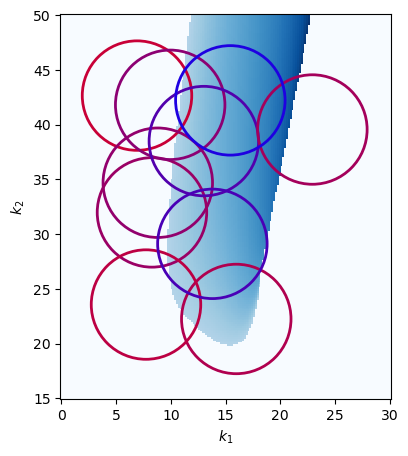

In [23]:
def circle_inside_proportion(Turing_region, X, Y, center, radius=5, num_points=360):
 
    cx, cy = center
    height, width = Turing_region.shape
    x_coords = X[0, :]
    y_coords = Y[:, 0]

    # Sample points along the circle
    theta = np.linspace(0, 2*np.pi, num_points)
    xs = cx + radius * np.cos(theta)
    ys = cy + radius * np.sin(theta)

    inside_count = 0
    for x, y in zip(xs, ys):
        ix = np.searchsorted(x_coords, x)
        iy = np.searchsorted(y_coords, y)
        if ix <= 0 or iy <= 0 or ix >= width or iy >= height:
            continue
        if Turing_region[iy, ix] > 0:
            inside_count += 1

    proportion_inside = inside_count / num_points
    return proportion_inside

# Example usage:
proportions = [circle_inside_proportion(Turing_region, X, Y, center, radius=5) for center in centers]

# Display results
for i, prop in enumerate(proportions):
    print(f"Circle {i+1} at {centers[i]}: {prop*100:.1f}% inside Turing region")

# Optional visualization
plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, Turing_region, shading="auto", cmap=plt.cm.Blues)
for (cx, cy), prop in zip(centers, proportions):
    circle_color = (1-prop, 0, prop)  # Red → outside, Blue → inside
    circle = plt.Circle((cx, cy), 5, color=circle_color, fill=False, lw=2)
    plt.gca().add_patch(circle)
plt.gca().set_aspect('equal')
plt.xlabel(r"$k_1$")
plt.ylabel(r"$k_2$")
plt.show()


In [24]:
# Compute rankings
# higher proportion → higher rank
ranked_indices = sorted(range(len(proportions)), key=lambda i: proportions[i], reverse=True)

print("Circle rankings based on proportion inside Turing region:")
for rank, idx in enumerate(ranked_indices, start=1):
    center = centers[idx]
    prop = proportions[idx]
    print(f"Rank {rank}: Circle at {center}, proportion inside = {prop*100:.1f}%")


Circle rankings based on proportion inside Turing region:
Rank 1: Circle at (15.435780869112834, 42.22370173376215), proportion inside = 88.3%
Rank 2: Circle at (13.795654887750612, 29.1180236073396), proportion inside = 71.4%
Rank 3: Circle at (13.0163162287472, 38.505358175996605), proportion inside = 67.8%
Rank 4: Circle at (9.941821708064465, 41.81767050770186), proportion inside = 45.0%
Rank 5: Circle at (8.809476727259664, 34.70080160935739), proportion inside = 42.8%
Rank 6: Circle at (8.277605748580367, 31.98994957390635), proportion inside = 39.4%
Rank 7: Circle at (22.930986987082083, 39.560409308951414), proportion inside = 35.6%
Rank 8: Circle at (15.978374140149128, 22.256385729291168), proportion inside = 31.1%
Rank 9: Circle at (7.732799803441843, 23.5727052642063), proportion inside = 26.4%
Rank 10: Circle at (6.911607466795349, 42.66000117829911), proportion inside = 21.7%


In [20]:

# Simulation function with two-step Euler-Maruyama and storage of k1, k2
def simulate_LC_TP_stationary(
    y0, t0, t_max, dt, c, dx, bound_cond, modelfuns, r,
    noise_amp, v_r, v_theta, cent_cyc, k1_0, k2_0,tangential_noise, radial_noise
):
    def apply_boundary(u):
        if bound_cond == 'Neumann':
            u[:, 0] = u[:, 1]
            u[:, -1] = u[:, -2]
            u[0, :] = u[1, :]
            u[-1, :] = u[-2, :]
        return u

    def laplacian(u):
        u = apply_boundary(u)
        return (
            -4 * u +
            np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
            np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1)
        ) / dx**2

    # Setup initial conditions
    dim = int(np.sqrt(len(y0[:-2]) // 2))  # infer grid size
    params = c
    mod_pars = params[2:]
    ss1 = solve_ss(k1_0,k2_0,params)[0]
    ss2 = solve_ss(k1_0,k2_0,params)[1]
    ss_1 = solve_ss2(k1_0,k2_0,params,[ss1,ss2])[0]
    ss_2 = solve_ss2(k1_0,k2_0,params,[ss1,ss2])[1]
    a = np.reshape(np.zeros(dim*dim) + float(ss_1), (dim,dim))
    b = np.reshape(np.zeros(dim*dim) + float(ss_2),(dim,dim))
    k1 = k1_0
    k2 = k2_0
    t = t0
    results = []  # List to store time, concentrations, and rate constants
    n = 0
    asum = 0
    asum_prev = 0
    while t < t_max:
        a = apply_boundary(a)
        b = apply_boundary(b)

        # Compute reaction terms for current concentrations
        f1_now, f2_now = modelfuns[0](a, b, mod_pars, k1, k2)
        g1_now, g2_now = modelfuns[1](k1, k2, r, v_r, v_theta, cent_cyc,tangential_noise, radial_noise)

        Da = params[0]
        Db = params[1]

        lap_a = laplacian(a)
        lap_b = laplacian(b)

        # First Euler-Maruyama step (predict)
        dydt_a = Da * lap_a + f1_now 
        dydt_b = Db * lap_b + f2_now 

        # Predict concentrations (Euler step)
        a_pred = a + dt * dydt_a
        b_pred = b + dt * dydt_b

        k1_pred = k1 + dt * g1_now
        k2_pred = k2 + dt * g2_now

        # Get the predicted reaction terms for the predicted concentrations
        f1_pred, f2_pred = modelfuns[0](a_pred, b_pred, mod_pars, k1_pred, k2_pred)
        g1_pred, g2_pred = modelfuns[1](k1_pred, k2_pred, r, v_r, v_theta, cent_cyc,tangential_noise, radial_noise)

        # Second Euler-Maruyama step (corrected)
        lap_a_pred = laplacian(a_pred)
        lap_b_pred = laplacian(b_pred)

        dydt_a_pred = Da * lap_a_pred + f1_pred
        dydt_b_pred = Db * lap_b_pred + f2_pred

        # Combine the two steps (Heun-like method)
        noise_a = a*(noise_amp * np.sqrt(dt) * np.random.randn(*a.shape))
        noise_b = b*(noise_amp * np.sqrt(dt) * np.random.randn(*b.shape))

        # Final update step using both predicted and current steps
        a += 0.5 * dt * (dydt_a + dydt_a_pred) + noise_a
        b += 0.5 * dt * (dydt_b + dydt_b_pred) + noise_b
        asum += (np.sum(0.5 * dt * (dydt_a + dydt_a_pred)))
        # Prevent negative or NaN values
        a = np.nan_to_num(a, nan=0.0, posinf=1e10, neginf=0.0)
        b = np.nan_to_num(b, nan=0.0, posinf=1e10, neginf=0.0)

        a = np.clip(a, 1e-10, None)  # Enforces a minimum of 0
        b = np.clip(b, 1e-10, None)

        
        # Compute the rate of change of k1 and k2 (using the limit cycle dynamics)
        k1 += 0.5 * dt * (g1_now + g1_pred)*0
        k2 += 0.5 * dt * (g2_now + g2_pred)*0
        # Store time, concentration, and parameters at each time step
        if int(n%(1/dt)) == 0.0: 
            results.append({
                't': t,   # Current time
                'u': a.copy(),  # Concentration of A (u)
                'v': b.copy(),  # Concentration of B (v)
                'k1': k1,  # Reaction rate constant k1
                'k2': k2})
            if t>20 and (abs(asum-asum_prev)<0.05):
                break
            asum_prev = asum
            asum = 0
            if t >t_max-2:
                print('not enough time')
        n += 1
        t += dt


    return results

def sample_points_in_circle(radius, center, num_points):

    angles = np.random.uniform(0, 2 * np.pi, num_points)
    
    # Random radii with square root for uniform distribution in area
    radii = radius * np.sqrt(np.random.uniform(0, 1, num_points))
    
    # Convert polar to Cartesian coordinates
    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)

    return np.row_stack((x, y))
def run_simulation_combo(cent_cycs, k1s,k2s):
            return simulate_LC_TP(
                y0=y0.copy(),
                t0=0,
                t_max=t_max,
                dt=dt,
                c=params,
                dx=dx,
                bound_cond=bound_cond,
                modelfuns=model_eq,
                r=r,
                noise_amp=noise_amp,
                v_r=v_r,
                v_theta=v_theta,
                cent_cyc=cent_cycs,
                k1_0 = k1s,
                k2_0 = k2s,
                tangential_noise = 5, 
                radial_noise = 5
        )

def run_simulation_combo2(k1s,k2s):
        return simulate_LC_TP_stationary(
            y0=y0.copy(),
            t0=0,
            t_max=300,
            dt=dt,
            c=params,
            dx=dx,
            bound_cond=bound_cond,
            modelfuns=model_eq,
            r=r, #Irrelevant
            noise_amp=noise_amp,
            v_r=v_r, #Irrelevant
            v_theta=v_theta, #Irrelevant
            cent_cyc=cent_cycs[0], #Irrelevant
            k1_0 = k1s,
            k2_0 = k2s,
            tangential_noise = 0, #Irrelevant
            radial_noise = 0 #Irrelevant
        )

In [ ]:

r, v_r, v_theta = 5, 0.01, 0.01 # 8, 0.3, 0.006

bound_cond = "Neumann"
nx = 50
ny = 50

model_eq = [Net8_pat, Net8_cycle] 

params = [
    1,       # D_A: activator diffusion
    25,      # D_B: inhibitor diffusion (moderately faster than D_A)
    3500,     # V_A: 
    3500,    # V_B: 
    0.5,     # k_BA: 
    1,    # b_A: 
    1,    # b_B: 
    6,     # μ_A: 
    8       # μ_B: 
] 
mod_pars = params[2:]
dx = 1
factor = 1 

y0 = np.zeros(2 * nx * ny + 2)

cent_cycs = []
k1s = []
k2s = []


In [5]:
with open("centers.pkl", "rb") as f:
    centers = pickle.load(f)

with open("entrances.pkl", "rb") as f:
    entrances = pickle.load(f)

print("Centers:", centers)
print("Entrances:", entrances)


Centers: [(6.911607466795349, 42.66000117829911), (8.809476727259664, 34.70080160935739), (8.277605748580367, 31.98994957390635), (9.941821708064465, 41.81767050770186), (15.978374140149128, 22.256385729291168), (13.0163162287472, 38.505358175996605), (22.930986987082083, 39.560409308951414), (7.732799803441843, 23.5727052642063), (13.795654887750612, 29.1180236073396), (15.435780869112834, 42.22370173376215)]
Entrances: [(10.439398093958204, 39.116740915363025), (9.572195802728938, 29.759318065732533), (9.72248548219913, 27.203267784255218), (10.269746954817379, 36.82843559315414), (18.234670987365856, 26.71834993098977), (9.913550048769746, 34.584536574292684), (21.61225480847366, 44.38336954526922), (12.261767119181147, 21.45410783832164), (18.76811169906901, 29.64211640405911), (10.574698390365873, 41.05328422927099)]


Prepare directories to store point data and LC data.

In [ ]:
dt = 0.002
noise_amp = 0.01
rad_noises = [5,5,5,5,5,5,5,5]
tan_noises = [5,5,5,5,5,5,5,5]
for i in range(len(centers)):
    k1s = [entrances[i][0]]*8
    k2s = [entrances[i][1]]*8
    cent_cycs = [[centers[i][0],centers[i][1]]]*8
    param_tris = list(zip(cent_cycs, k1s,k2s))
    param_pairs = list(zip(rad_noises, tan_noises))
    t_max = 630
    v_theta = 0.01
    for j in range(0,5):
        print(centers[i])
        results_all = Parallel(n_jobs=8)(
            delayed(run_simulation_combo)(cent_cycs, k1s,k2s) for cent_cycs, k1s,k2s in param_tris
        )
        print('hi1')
        for q in range(len(param_tris)):
            results = results_all[q]
            k1_values = [res['k1'] for res in results]
            k2_values = [res['k2'] for res in results]
            u_values = [res['u'] for res in results]
            v_values = [res['v'] for res in results]
            t_values = [res['t'] for res in results]
            np.savez(f"fig4_data/proper_LCs/EM_reprod_rad_noise{5}_tan_noise{5}_cent_cyc{np.round(centers[i],3)}_ent_{np.round(entrances[i],3)}_{q+(j*8)}.npz", k1 = k1_values, k2 = k2_values, u = u_values, v = v_values, t = t_values)
        print('hi1')
    circ_points = sample_points_in_circle(5,[centers[i][0],centers[i][1]],600)
    k1s = circ_points[0]
    k2s = circ_points[1]
    param_pairs = list(zip(k1s, k2s))
    batch_size = 8
    for j in range(0, len(param_pairs), batch_size):
        batch = param_pairs[j:j+batch_size]
        results_all = Parallel(n_jobs=8)(
            delayed(run_simulation_combo2)(k1s, k2s) for k1s, k2s in batch
        )
        for q in range(0,8):
            results = results_all[q]
            k1_values = [res['k1'] for res in results]
            k2_values = [res['k2'] for res in results]
            u_values = [res['u'] for res in results]
            v_values = [res['v'] for res in results]
            t_values = [res['t'] for res in results]
            np.savez(f"fig4_data/proper_Points/EM_reprod_points_cent_cyc{np.round(centers[i],3)}_{q+j}.npz", k1 = k1_values, k2 = k2_values, u = u_values, v = v_values, t = t_values)



In [ ]:
#Process the limit cycle data.
rad_noises = [5,5,5,5,5,5,5,5]
tan_noises = [5,5,5,5,5,5,5,5]
#55%, (18.27, 28.37) | Coverage: 55.00% | Entry: (20.11, 33.02)
#85% (14.59, 36.63) | Coverage: 85.00% | Entry: (9.98, 34.70)

nsamp = len(centers)
entropy_dict = {cents: [] for cents in range(nsamp)}
print(entropy_dict)

def extract_cent_cyc(filename):
    # match content inside cent_cyc[ ... ]
    match = re.search(r'cent_cyc\[\s*([0-9.+-eE]+)\s+([0-9.+-eE]+)\s*\]', filename)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None



for i in range(len(centers)):
    directory = 'fig4_data/proper_LCs' #Modify appropriately to match your directory.
    k = centers[i]
    n = 0

    for filename in os.listdir(directory):
        same_cycs_key = extract_cent_cyc(filename)
        if same_cycs_key is None:
            print("none at", filename )
            continue
        if (np.round(same_cycs_key,3)[0] == np.round(k,3)[0]) and (np.round(same_cycs_key,3)[1] == np.round(k,3)[1]):
            res = np.load(f'{directory}/{filename}')
            entropy_list = []
            n = n+1
            print(filename, n)
            for o in range(0,len(res['k1'])):
                FS1 = np.fft.fft2(res['u'][o], (50, 50))
                power_spectrum_normS1 = np.abs(FS1)**2 / np.sum(np.abs(FS1)**2)
                entropy_list.append(-np.sum(power_spectrum_normS1 * np.log2(power_spectrum_normS1+ 0.00000000000000001)))
            entropy_dict[i].append(entropy_list)
        else:
            continue

In [ ]:
#Save the LC data.
with open('fig4_data/proper_LCs/LC_entropy_dict.pkl', 'wb') as f:
    pickle.dump(entropy_dict, f)

with open('fig4_data/proper_LCs/LC_entropy_dict.pkl', 'rb') as f:
    entropy_dict = pickle.load(f)

In [ ]:
#Compute mean trajectorie and sd
nsamp = len(centers)
sd_across_dict = {cents: [] for cents in range(nsamp)}
mean_across_dict = {cents: [] for cents in range(nsamp)}
for i in range(nsamp):
    for j in range(len(entropy_dict[i][0])):#630
        sums = 0
        vals = []
        for p in range(len(entropy_dict[i])): #40
            sums += entropy_dict[i][p][j]
            vals.append(entropy_dict[i][p][j])
        mean_across_dict[i].append(sums/len(entropy_dict[i]))
        sd_across_dict[i].append(np.std(vals)) 

Figure 4D

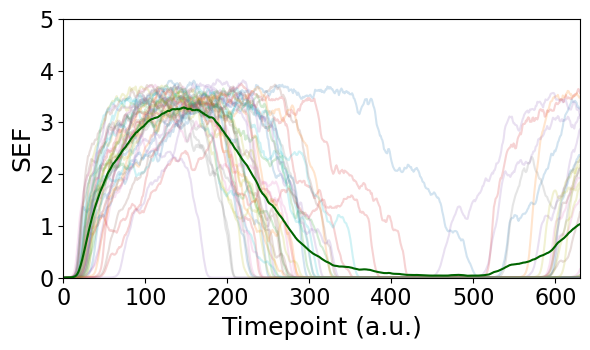

In [27]:
ind_of_i = 3
plt.figure(figsize=(6, 3.6))

for i in range(len(entropy_dict[0])): #40
    plt.plot(entropy_dict[ind_of_i][i],alpha = 0.2)
plt.plot(mean_across_dict[ind_of_i],'darkgreen')
#clamped = [max(m - s, 0) for m, s in zip(mean_across_t, sd_across_t)]
#plt.plot(clamped, color='blue')
#plt.plot(np.add(mean_across_t,sd_across_t),'blue')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Timepoint (a.u.)", fontsize = 18)
plt.ylabel("SEF", fontsize = 18)


plt.xlim(0,630)
plt.ylim(0,5)
plt.tight_layout()
plt.savefig("fig4_LCs_ensemble.png")
plt.show()

In [ ]:
# Compute SEF and location of each point.

nsamp = len(centers)
entropy_point_data_dict = {cents: [] for cents in range(nsamp)}
k1_points_dict = {cents: [] for cents in range(nsamp)}
k2_points_dict = {cents: [] for cents in range(nsamp)}

import re

def extract_cent_cyc2(filename):
    match = re.search(r'cent_cyc\[\s*([0-9.+-eE]+)\s+([0-9.+-eE]+)\s*\]', filename)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None

nones = 0
for i in range(len(centers)):
    directory = 'fig4_data/proper_Points'
    k = centers[i]
    print(i)
    for filename in os.listdir(directory):
        same_cycs_key = extract_cent_cyc2(filename)
        if same_cycs_key is None:
            nones = nones+1 
            continue
        if (np.round(same_cycs_key,3)[0] == np.round(k,3)[0]) and (np.round(same_cycs_key,3)[1] == np.round(k,3)[1]):
            res = np.load(f'{directory}/{filename}')
            FS1 = np.fft.fft2(res['u'][-1], (50, 50))
            power_spectrum_normS1 = np.abs(FS1)**2 / np.sum(np.abs(FS1)**2)
            entropy_point_data_dict[i].append(-np.sum(power_spectrum_normS1 * np.log2(power_spectrum_normS1+ 0.00000000000000001)))
            k1_points_dict[i].append(res['k1'][-1])
            k2_points_dict[i].append(res['k2'][-1])
        else:
            continue
print(nones)
with open('fig4_data/Points/Points_entropy_dict.pkl', 'wb') as f:
    pickle.dump(entropy_point_data_dict, f)

with open('fig4_data/Points/Points_entropy_dict.pkl', 'rb') as f:
    entropy_point_data_dict = pickle.load(f)
    
with open('fig4_data/Points/k1_points_dict.pkl', 'wb') as f:
    pickle.dump(k1_points_dict, f)
with open('fig4_data/Points/k1_points_dict.pkl', 'rb') as f:
    k1_points_dict = pickle.load(f)
    
with open('fig4_data/Points/k2_points_dict.pkl', 'wb') as f:
    pickle.dump(k2_points_dict, f)
with open('fig4_data/Points/k2_points_dict.pkl', 'rb') as f:
    k2_points_dict = pickle.load(f)

This is the order that we will plot the data, dependent on mean SEF sd values

In [38]:
data_list = list(sd_across_dict.values())

# Build long-form DataFrame
df = pd.DataFrame({
    'SEF': np.concatenate(data_list),
    'Dataset': np.repeat(
        [f'{i+1}' for i in range(len(data_list))],
        [len(arr) for arr in data_list]
    )
})

# Compute mean SEF per dataset and sort
order = df.groupby("Dataset")["SEF"].mean().sort_values().index.tolist()
print(order)

['8', '1', '3', '5', '2', '4', '6', '10', '9', '7']


And this is the order of colors, dependent on proportion of circle within the Turing island

In [85]:
idx_list = []
for rank, idx in enumerate(ranked_indices, start=1):
    center = centers[idx]
    prop = proportions[idx]
    print(f"Rank {rank}: Circle at {center},index {idx} proportion inside = {prop*100:.1f}%")
    idx_list.append(idx)
idx_list = idx_list[::-1]
print(idx_list)

Rank 1: Circle at (15.435780869112834, 42.22370173376215),index 9 proportion inside = 88.3%
Rank 2: Circle at (13.795654887750612, 29.1180236073396),index 8 proportion inside = 71.4%
Rank 3: Circle at (13.0163162287472, 38.505358175996605),index 5 proportion inside = 67.8%
Rank 4: Circle at (9.941821708064465, 41.81767050770186),index 3 proportion inside = 45.0%
Rank 5: Circle at (8.809476727259664, 34.70080160935739),index 1 proportion inside = 42.8%
Rank 6: Circle at (8.277605748580367, 31.98994957390635),index 2 proportion inside = 39.4%
Rank 7: Circle at (22.930986987082083, 39.560409308951414),index 6 proportion inside = 35.6%
Rank 8: Circle at (15.978374140149128, 22.256385729291168),index 4 proportion inside = 31.1%
Rank 9: Circle at (7.732799803441843, 23.5727052642063),index 7 proportion inside = 26.4%
Rank 10: Circle at (6.911607466795349, 42.66000117829911),index 0 proportion inside = 21.7%
[0, 7, 4, 6, 2, 1, 3, 5, 8, 9]


Figure 4F

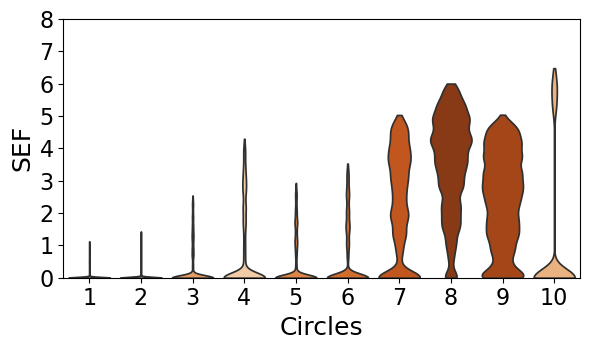

In [99]:
# Convert dict values to list
data_list = list(entropy_point_data_dict.values())
plt.figure(figsize=(6, 3.6))
df = pd.DataFrame({
    'SEF': np.concatenate(data_list),
    'Dataset': np.repeat(
        [f'{i+1}' for i in range(len(data_list))],
        [len(arr) for arr in data_list]
    )
})
dataset_labels = [str(i+1) for i in range(10)]  
oranges = sns.color_palette("Oranges", n_colors=len(dataset_labels))
dataset_to_color = {str(idx+1): oranges[r] for r, idx in enumerate(idx_list)}

palette = {dataset: dataset_to_color[dataset] for dataset in order}
sns.violinplot(
    x='Dataset', y='SEF', hue='Dataset', data=df,
    palette=palette, legend=False, inner=None, cut=0,
    bw_method=0.12, order=order
) 

plt.xticks(rotation=0)
plt.xlabel("Circles",fontsize = 18)
plt.ylabel("SEF",fontsize = 18)
plt.ylim(0,8)
plt.xticks(fontsize=16)

plt.xticks(ticks=range(10), labels=['1','2','3','4','5','6','7','8','9','10'])
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("fig4_violin.png")
plt.show()

Figure 4G

/var/tmp/pbs.1227380.pbs-7/ipykernel_1441900/386252194.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dataset', y='SEF_std', data=std_df, palette=palette,order = order)


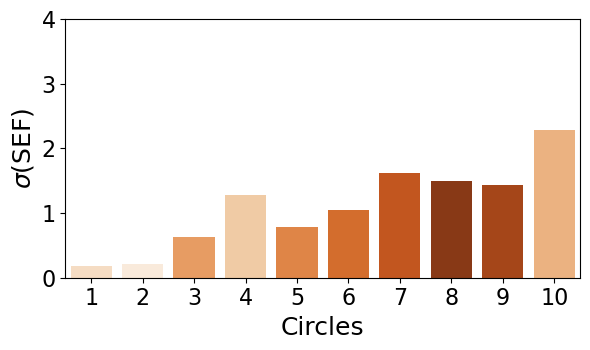

In [91]:
data_list = list(entropy_point_data_dict.values())

df = pd.DataFrame({
    'SEF': np.concatenate(data_list),
    'Dataset': np.repeat(
        np.arange(1, len(data_list) + 1),
        [len(arr) for arr in data_list]
    )
})

# ⬇️ Compute standard deviation of SEF for each dataset
std_df = df.groupby("Dataset", as_index=False).agg({'SEF': 'std'})
std_df.rename(columns={'SEF': 'SEF_std'}, inplace=True)

oranges = sns.color_palette("Oranges", n_colors=len(dataset_labels))

# idx_list contains dataset indices ordered by proportion, lowest → highest
# So map dataset index → color
dataset_to_color = {str(idx+1): oranges[r] for r, idx in enumerate(idx_list)}

# Now build palette for the violin plot based on the axis order
palette = {dataset: dataset_to_color[dataset] for dataset in order}
# Plot
plt.figure(figsize=(6, 3.6))
sns.barplot(x='Dataset', y='SEF_std', data=std_df, palette=palette,order = order)

plt.xlabel("Circles", fontsize=18)
plt.ylabel(r"$\sigma(\mathrm{SEF})$", fontsize=18)
plt.ylim(0, 4)
plt.xticks(fontsize=16)

plt.xticks(ticks=range(10), labels=['1','2','3','4','5','6','7','8','9','10'])
plt.yticks(fontsize=16, ticks=np.arange(0,5),labels=['0','1','2','3','4'])
plt.tight_layout()
plt.savefig("fig4_bar_point.png")
plt.show()

Figure 4E

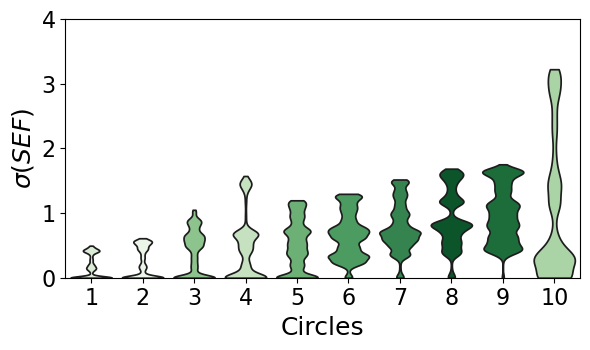

In [92]:

data_list = list(sd_across_dict.values())
plt.figure(figsize=(6, 3.6))

df = pd.DataFrame({
    'SEF': np.concatenate(data_list),
    'Dataset': np.repeat(
        [f'{i+1}' for i in range(len(data_list))],
        [len(arr) for arr in data_list]
    )
})
greens = sns.color_palette("Greens", n_colors=len(dataset_labels))

dataset_to_color = {str(idx+1): greens[r] for r, idx in enumerate(idx_list)}

palette = {dataset: dataset_to_color[dataset] for dataset in order}

sns.violinplot(x='Dataset', y="SEF", hue='Dataset', data=df ,legend=False, inner = None, cut = 0,
              bw_method=0.12,palette = palette,order = order)  # smaller values = less smoothing
plt.xticks(rotation=0)
plt.xlabel("Circles",fontsize = 18)
plt.ylabel(f"$\sigma(SEF)$",fontsize = 18)
plt.ylim(0,4)
plt.xticks(fontsize=16)
plt.xticks(ticks=range(10), labels=['1','2','3','4','5','6','7','8','9','10'])

plt.yticks(fontsize=16, ticks=np.arange(0,5),labels=['0','1','2','3','4'])
plt.tight_layout()
plt.savefig("fig4_violin_LCs.png")
plt.show()


Figure 4H

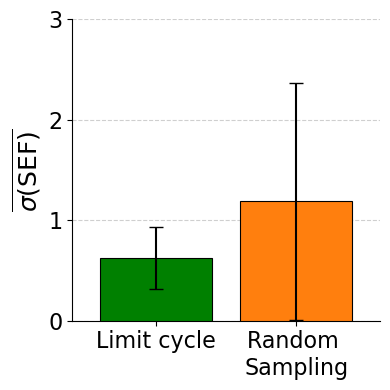

In [98]:
nsamp = len(centers)
LC_vals = []
for i in range(nsamp):
    LC_vals.append(np.mean(sd_across_dict[i]))
point_vals = []
for i in range(nsamp):
    point_vals.append(np.mean(entropy_point_data_dict[i]))
    
labels = ['Limit cycle', 'Random \nSampling']
means = [np.mean(LC_vals),np.mean(point_vals)]
errors = [np.std(LC_vals,ddof=1),np.std(point_vals,ddof=1)]

x = np.array([0, 0.5])
bar_width = 0.4

fig, ax = plt.subplots(figsize=(4, 4))
bars = ax.bar(x, means, width=bar_width, color=['green', '#ff7f0e'], edgecolor='black', linewidth=0.8,zorder = 3)

ax.errorbar(x, means, yerr=errors, fmt='none', color='black', capsize=5, zorder=3)
ax.set_ylabel(r"$\overline{\sigma(\mathrm{SEF})}$", fontsize = 18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 18)

ax.set_xlim(-0.3, 0.8)  
ax.set_ylim(0, 3)
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylim(bottom=0)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.yticks(ticks = [0,1,2,3], label = [0,1,2,3],fontsize=16)
plt.xticks(fontsize=16)

plt.tight_layout()

plt.savefig("fig4_bar.png")
plt.show()


Supplementary figure 3

In [ ]:
def run_simulation_combo_supp(rad_noises,tan_noises):
    return simulate_LC_TP(
        y0=y0.copy(),
        t0=0,
        t_max=t_max,
        dt=dt,
        c=params,
        dx=dx,
        bound_cond=bound_cond,
        modelfuns=model_eq,
        r=r,
        noise_amp=noise_amp,
        v_r=v_r,
        v_theta=v_theta,
        cent_cyc=cent_cyc,
        k1_0 = k1,
        k2_0 = k2,
        tangential_noise = tan_noises, 
        radial_noise = rad_noises
    )
k1 = entrances[3][0]
k2 = entrances[3][1]
dt = 0.002
noise_amp = 0.01
cent_cyc = [centers[3][0],centers[3][1]]
t_max = 630
v_theta = 0.01
for j in range(0,6):
    rad_noises = [np.linspace(0,5,6)[j]]*8
    tan_noises = [np.linspace(0,5,6)[j]]*8
    param_pairs = list(zip(rad_noises, tan_noises))
    results_all = Parallel(n_jobs=8)(
        delayed(run_simulation_combo_supp)(rad, tan) 
        for rad, tan in param_pairs
    )
    for q in range(len(param_pairs)):
        results = results_all[q]
        k1_values = [res['k1'] for res in results]
        k2_values = [res['k2'] for res in results]
        u_values = [res['u'] for res in results]
        v_values = [res['v'] for res in results]
        t_values = [res['t'] for res in results]
        np.savez(f"fig4_data/supplementary4_v2/EM_reprod_rad_noise{rad_noises[0]}_tan_noise{tan_noises[0]}_{q}.npz", k1 = k1_values, k2 = k2_values, u = u_values, v = v_values, t = t_values)


In [ ]:
def extract_rad_noise(filename):
    match =re.search(r'_rad_noise([0-9.]+)', filename)
    if match:
        value = float(match.group(1))
        return value

    return None


rad_noise_list = np.linspace(0,5,6)
tan_noise_list = np.linspace(0,5,6)
entropy_dict_noi = {noi: [] for noi in rad_noise_list}
for i in range(6):
    directory = 'fig4_data/supplementary4_v2'
    for filename in os.listdir(directory):
        filename = filename.strip() 
        rad_noise = extract_rad_noise(filename)
        if same_cycs_key is None:
            print("none at", filename )
            continue
        if  rad_noise_list[i] == rad_noise:
            res = np.load(f'{directory}/{filename}')
            entropy_list = []
            print(filename)
            for o in range(0,len(res['k1'])):
                FS1 = np.fft.fft2(res['u'][o], (50, 50))
                power_spectrum_normS1 = np.abs(FS1)**2 / np.sum(np.abs(FS1)**2)
                entropy_list.append(-np.sum(power_spectrum_normS1 * np.log2(power_spectrum_normS1+ 0.00000000000000001)))
            entropy_dict_noi[i].append(entropy_list)
        else:
            continue

In [ ]:

sd_across_dict_noi = {noi: [] for noi in rad_noise_list}
mean_across_dict_noi = {noi: [] for noi in rad_noise_list}
for i in rad_noise_list:
    print(i)
    for j in range(len(entropy_dict_noi[i][0])):#630
        sums = 0
        vals = []
        for p in range(len(entropy_dict_noi[i])): #40
            sums += entropy_dict_noi[i][p][j]
            vals.append(entropy_dict_noi[i][p][j])
        mean_across_dict_noi[i].append(sums/len(entropy_dict_noi[i]))
        sd_across_dict_noi[i].append(np.std(vals))

        

0.0
1.0
2.0
3.0
4.0
5.0


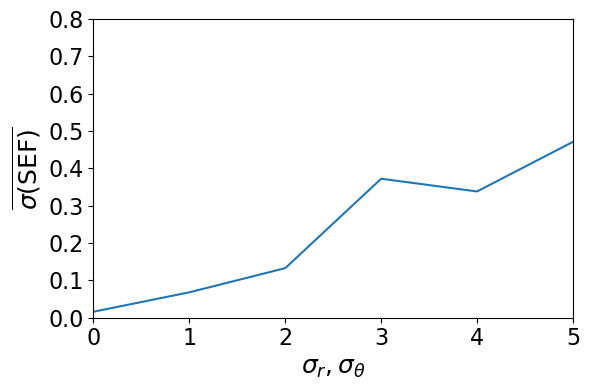

In [131]:

LC_vals_noi = []
for i in rad_noise_list:
    print(i)
    LC_vals_noi.append(np.mean(sd_across_dict_noi[i]))
plt.figure(figsize = (6,4))
plt.plot(rad_noise_list,LC_vals_noi)
plt.xlabel(r"$\sigma_r, \sigma_\theta$", fontsize=18)
plt.ylabel(r"$\overline{\sigma(\mathrm{SEF})}$", fontsize=18)
plt.xlim(0,5)
plt.ylim(0,0.8)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
plt.savefig("supplementary4.png")


# Figure 4 B,C
Simulate a limit cycle trajectory with simulate_TP_LC, with desired tangential and radial noise, and refer using np.load. Then, follow the execution below

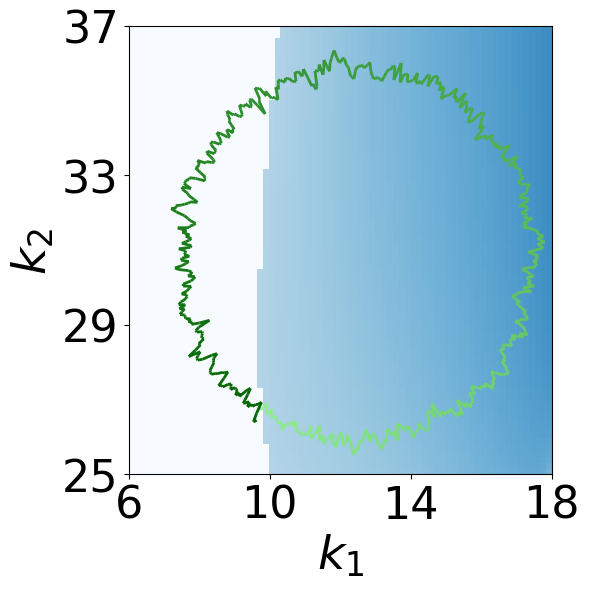

In [4]:
data = np.load('turing_region.npz')
X = data['X']
Y = data['Y']
Turing_region = data['Turing_region']

# Load your data
res = np.load('fig4_rad_noise5_graph0.npz')
x = res['k1']
y = res['k2']

# Create segments for LineCollection
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a colormap from lightgreen to darkgreen
cmap = LinearSegmentedColormap.from_list("green_gradient", ["lightgreen", "darkgreen"])

# Normalize the color along the line

norm = Normalize(vmin=0, vmax=len(x))

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(np.arange(len(x)))
lc.set_linewidth(2)

fig, ax = plt.subplots(figsize = (6,6))
ax.add_collection(lc)

plt.pcolormesh(X, Y, Turing_region, shading="auto", cmap = 'Blues')

ax.set_xlim(6, 18)
ax.set_xlabel(r"$k_1$",fontsize = 34)
ax.set_xticks([6, 10,  14, 18]) 
ax.set_ylim(25, 37)

ax.set_ylabel(r"$k_2$",fontsize = 34)

ax.set_yticks([25, 29,  33, 37])
ax.tick_params(axis='both', labelsize=32)
plt.tight_layout()
plt.savefig('fig4_radial_noise')
plt.show()

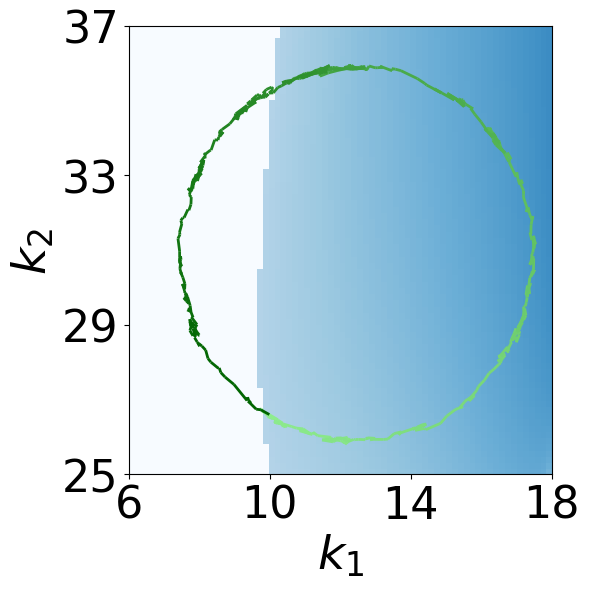

In [5]:
res = np.load('fig4_tan_noise5_graph1.npz')
x = res['k1']
y = res['k2']

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

cmap = LinearSegmentedColormap.from_list("green_gradient", ["lightgreen", "darkgreen"])

norm = Normalize(vmin=0, vmax=len(x))

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(np.arange(len(x)))
lc.set_linewidth(2)

fig, ax = plt.subplots(figsize = (6,6))
ax.add_collection(lc)

plt.pcolormesh(X, Y, Turing_region, shading="auto", cmap = 'Blues')

ax.set_xlim(6, 18)
ax.set_xlabel(r"$k_1$",fontsize = 34)
ax.set_xticks([6, 10,  14, 18]) 
ax.set_ylim(25, 37)

ax.set_ylabel(r"$k_2$",fontsize = 34)

ax.set_yticks([25, 29,  33, 37])
ax.tick_params(axis='both', labelsize=32)
plt.tight_layout()
plt.savefig('fig4_tangential_noise')
plt.show()